In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from data_quality import *
import tensorflow as tf
import tensorflow_data_validation as tfdv
import time
import warnings
from tensorflow_metadata.proto.v0 import schema_pb2
warnings.simplefilter('ignore')

In [2]:
clean_flights, dirty_flights = partition_data_files('tmp/FLIGHTS/*.csv')
clean_fb, dirty_fb = partition_data_files('tmp/FBPosts2/*.csv')

In [3]:
start_time = time.time()
print(is_acceptable(clean_flights[0:5], dirty_flights[5:6],method='tfdv'))
print("Finished in: {:.2f} seconds".format(time.time()-start_time))

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Schema successfully updated for all 5 files
False
Finished in: 25.02 seconds


In [54]:
start_time = time.time()
print(is_acceptable(clean_fb[0:5], dirty_fb[5:6]))
print("Finished in: {:.2f} seconds".format(time.time()-start_time))

Schema successfully updated for all 5 files
True
Finished in: 38.18 seconds


In [7]:
fb_analysis = pd.DataFrame(columns=['train_type', 'batch_size', 'test_batch', 'clean_correct', 'dirty_correct'])
counter = 0

for train_type in ['rolling', 'increasing']:
    for batch_size in range(1, 10):
        for i in range(len(clean_fb)-batch_size):
            row = analysis(i, train_type, clean_fb, dirty_fb, batch_size, 'tfdv')
            fb_analysis.loc[counter] = row
            counter = counter + 1
fb_analysis.to_csv('fb_batch_analysis_tfdv.csv', index = False)

Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files


KeyboardInterrupt: 

In [ ]:
fb_accuracy = get_accuracy(fb_analysis)
fb_accuracy.to_csv('fb_accuracy_tfdv.csv', index = False)

In [4]:
flights_analysis = pd.DataFrame(columns=['train_type', 'batch_size', 'test_batch', 'clean_correct', 'dirty_correct'])
counter = 0

for train_type in ['rolling', 'increasing']:
    for batch_size in range(1, 10):
        for i in range(len(clean_flights)-batch_size):
            row = analysis(i, train_type, clean_flights, dirty_flights, batch_size, 'tfdv')
            flights_analysis.loc[counter] = row
            counter = counter + 1
flights_analysis.to_csv('flights_batch_analysis_tfdv.csv', index = False)

Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for all 1 files
Schema successfully updated for 

Schema successfully updated for all 4 files
Schema successfully updated for all 4 files
Schema successfully updated for all 4 files
Schema successfully updated for all 4 files
Schema successfully updated for all 4 files
Schema successfully updated for all 4 files
Schema successfully updated for all 4 files
Schema successfully updated for all 4 files
Schema successfully updated for all 4 files
Schema successfully updated for all 4 files
Schema successfully updated for all 4 files
Schema successfully updated for all 4 files
Schema successfully updated for all 4 files
Schema successfully updated for all 4 files
Schema successfully updated for all 4 files
Schema successfully updated for all 4 files
Schema successfully updated for all 4 files
Schema successfully updated for all 4 files
Schema successfully updated for all 4 files
Schema successfully updated for all 4 files
Schema successfully updated for all 4 files
Schema successfully updated for all 4 files
Schema successfully updated for 

Schema successfully updated for all 7 files
Schema successfully updated for all 7 files
Schema successfully updated for all 7 files
Schema successfully updated for all 7 files
Schema successfully updated for all 8 files
Schema successfully updated for all 8 files
Schema successfully updated for all 8 files
Schema successfully updated for all 8 files
Schema successfully updated for all 8 files
Schema successfully updated for all 8 files
Schema successfully updated for all 8 files
Schema successfully updated for all 8 files
Schema successfully updated for all 8 files
Schema successfully updated for all 8 files
Schema successfully updated for all 8 files
Schema successfully updated for all 8 files
Schema successfully updated for all 8 files
Schema successfully updated for all 8 files
Schema successfully updated for all 8 files
Schema successfully updated for all 8 files
Schema successfully updated for all 8 files
Schema successfully updated for all 8 files
Schema successfully updated for 

Schema successfully updated for all 17 files
Schema successfully updated for all 18 files
Schema successfully updated for all 18 files
Schema successfully updated for all 19 files
Schema successfully updated for all 19 files
Schema successfully updated for all 20 files
Schema successfully updated for all 20 files
Schema successfully updated for all 21 files
Schema successfully updated for all 21 files
Schema successfully updated for all 22 files
Schema successfully updated for all 22 files
Schema successfully updated for all 23 files
Schema successfully updated for all 23 files
Schema successfully updated for all 24 files
Schema successfully updated for all 24 files
Schema successfully updated for all 25 files
Schema successfully updated for all 25 files
Schema successfully updated for all 26 files
Schema successfully updated for all 26 files
Schema successfully updated for all 27 files
Schema successfully updated for all 27 files
Schema successfully updated for all 28 files
Schema suc

Schema successfully updated for all 28 files
Schema successfully updated for all 28 files
Schema successfully updated for all 29 files
Schema successfully updated for all 29 files
Schema successfully updated for all 30 files
Schema successfully updated for all 30 files
Schema successfully updated for all 6 files
Schema successfully updated for all 6 files
Schema successfully updated for all 7 files
Schema successfully updated for all 7 files
Schema successfully updated for all 8 files
Schema successfully updated for all 8 files
Schema successfully updated for all 9 files
Schema successfully updated for all 9 files
Schema successfully updated for all 10 files
Schema successfully updated for all 10 files
Schema successfully updated for all 11 files
Schema successfully updated for all 11 files
Schema successfully updated for all 12 files
Schema successfully updated for all 12 files
Schema successfully updated for all 13 files
Schema successfully updated for all 13 files
Schema successfull

Schema successfully updated for all 25 files
Schema successfully updated for all 26 files
Schema successfully updated for all 26 files
Schema successfully updated for all 27 files
Schema successfully updated for all 27 files
Schema successfully updated for all 28 files
Schema successfully updated for all 28 files
Schema successfully updated for all 29 files
Schema successfully updated for all 29 files
Schema successfully updated for all 30 files
Schema successfully updated for all 30 files


In [5]:
flights_accuracy = get_accuracy(flights_analysis)
flights_accuracy.to_csv('flights_accuracy_tfdv.csv', index = False)

In [ ]:
plot_batch('facebook', fb_analysis, range(1, 10))

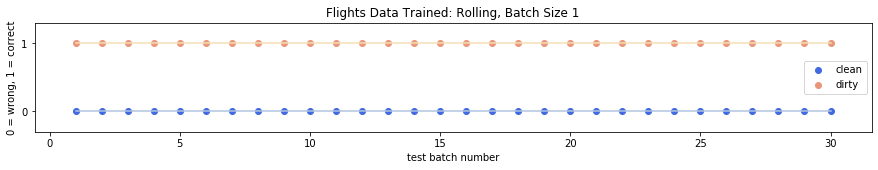

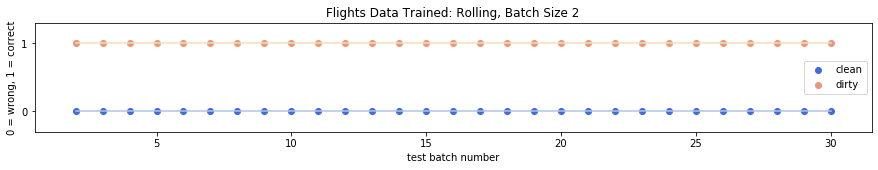

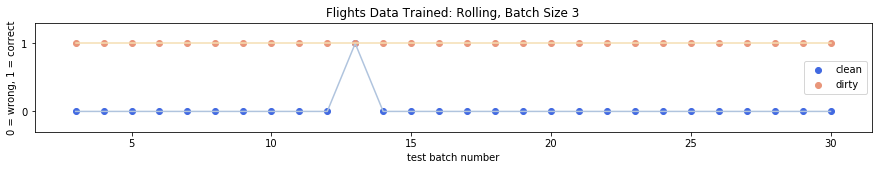

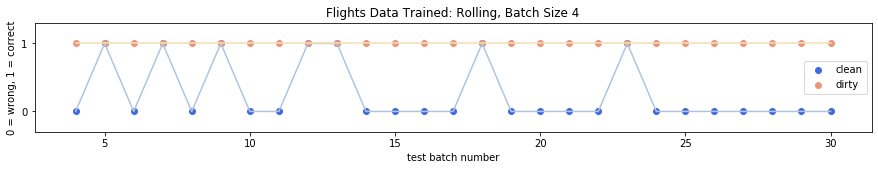

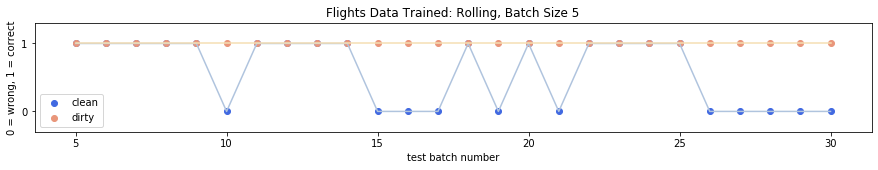

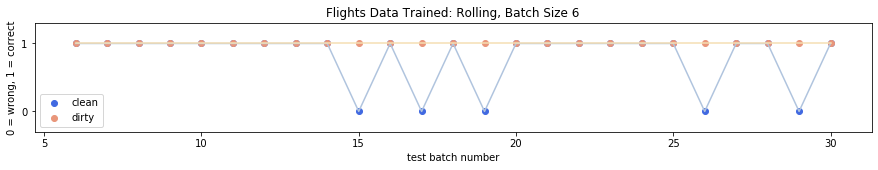

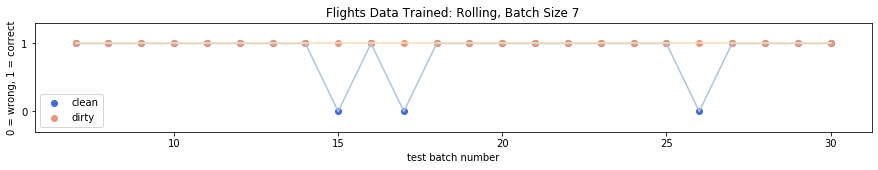

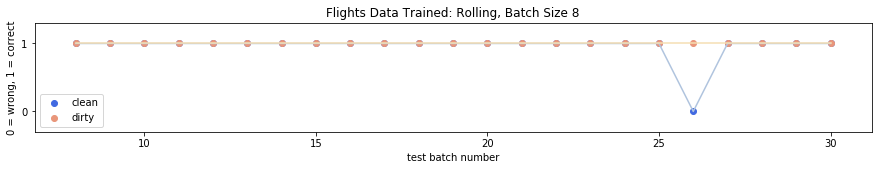

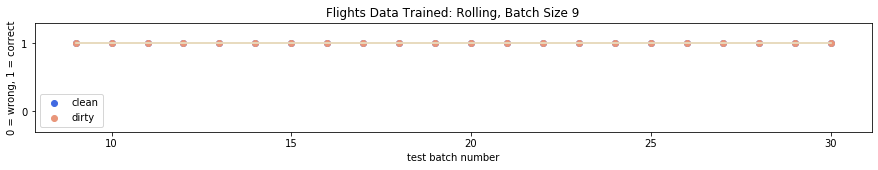

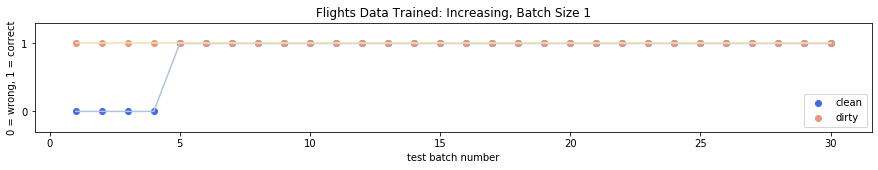

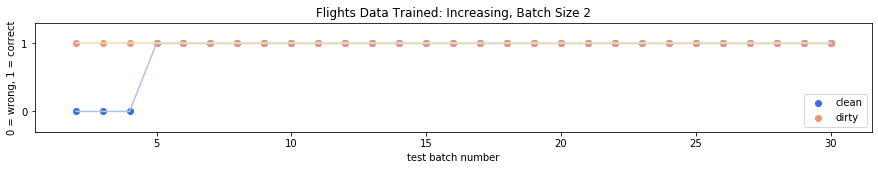

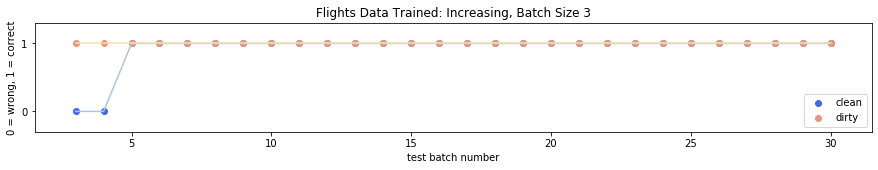

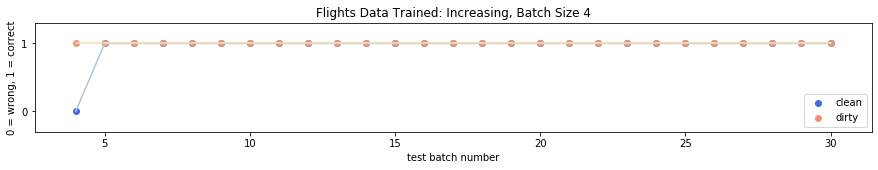

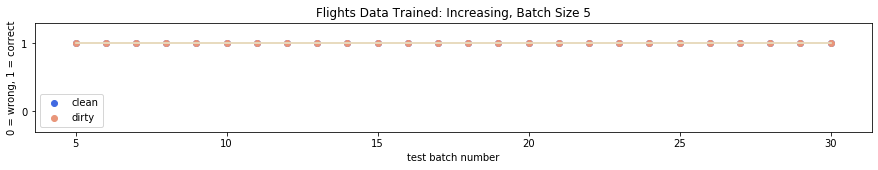

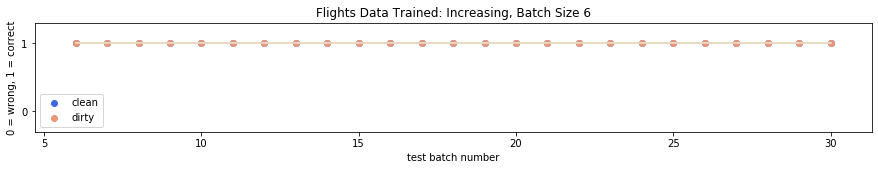

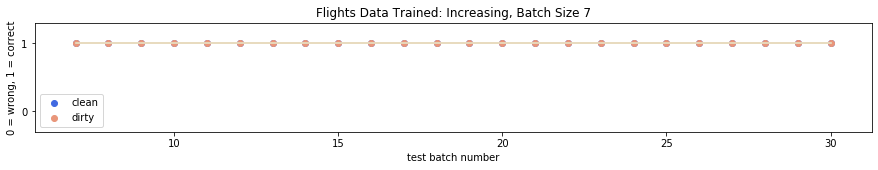

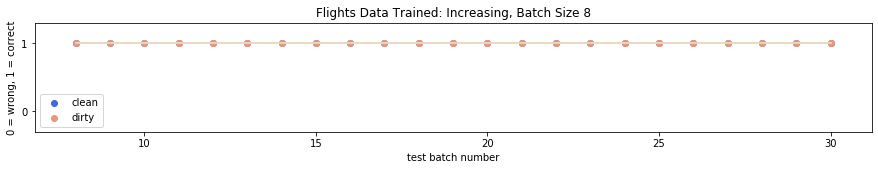

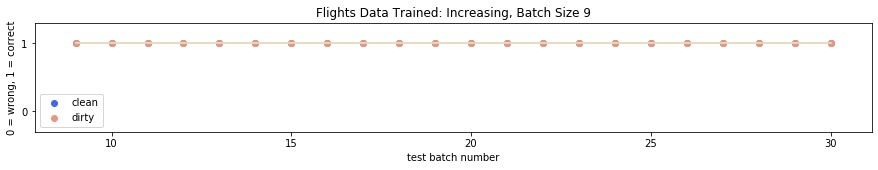

In [8]:
plot_batch('flights', flights_analysis, range(1, 10))